In [1]:
import re
import praw
import json
import string
import numpy as np
import pandas as pd
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from praw.models import MoreComments
from transformers import pipeline

In [2]:
# this is the API call stuff
reddit = praw.Reddit(
    client_id = "qJsvLNd6Goxgqz4LZ6yEbg",
    client_secret = "KIUx33wL7W434pIy4lru06slhDjAEQ",
    user_agent = "posts_ds" 
)

# selecting a specific subreddit
subreddit = reddit.subreddit("ufc")

# calling the top 10 reddit posts
new_posts = subreddit.new(limit=10)

Version 7.7.1 of praw is outdated. Version 7.8.1 was released Friday October 25, 2024.


In [3]:
def remove_urls_specialchar(text, replacement_text=''):
    url_pattern = re.compile(r'https?://\S+|www\.\S+|gif\S+')
    text_without_urls = url_pattern.sub(replacement_text, text)
    reddit_tokens = re.compile(r'\br/\w+|\bu/\w+')
    text_without_tokens = reddit_tokens.sub(replacement_text, text_without_urls)
    special_char = re.compile(r'[^\w\s.,!?]|(?<![\U0001F600-\U0001F64F\U0001F300-\U0001F5FF\U0001F680-\U0001F6FF\U0001F700-\U0001F77F\U0001F780-\U0001F7FF\U0001F800-\U0001F8FF\U0001F900-\U0001F9FF\U0001FA00-\U0001FA6F\U0001FA70-\U0001FAFF\U00002702-\U000027B0\U0001F1E6-\U0001F1FF])')
    clean_text = special_char.sub(replacement_text, text_without_tokens)
    return clean_text

In [4]:
# printing the titles for the top 10 posts
def get_data(new_posts = new_posts):
    data_dict = {}
    for post in new_posts:
        # Get the title of the post
        post_title = post.title
    
        # fetch all comments
        post.comments.replace_more(limit=None)
    
        # Create a list of all comment bodies for the post
        comments = [comment.body for comment in post.comments.list()]
    
        # Add the list of comments to the dictionary under the post's title
        if post_title in data_dict:
            data_dict[post_title].extend(comments)  # Append if the title already exists
        else:
            data_dict[post_title] = comments  # Add a new entry
    
    return data_dict

In [5]:
reddit_data_dict = get_data()

In [6]:
def init_preprocess(data = reddit_data_dict):
    stop_words = set(stopwords.words('english'))
    clean_data_dict = {}
    clean_comments = []

    for val in data.values():
        for sub_val in val:
            # removing the urls from the comments
            sub_val = remove_urls_specialchar(sub_val)
            
            # removing all the punctuations from the comments
            sub_val = sub_val.translate(str.maketrans('', '',
                                        string.punctuation))
            sub_val = sub_val.lower()
            word_tokens = word_tokenize(sub_val)
            filtered_sentence = [w for w in word_tokens if not w.lower() in stop_words]
            filtered_sentence = []
            for w in word_tokens:
                if w not in stop_words:
                    filtered_sentence.append(w)
            clean_comments.append(filtered_sentence)
    
    for title in data.keys():
        clean_data_dict[title] = clean_comments

    return clean_data_dict

In [7]:
# Initialize the sentiment analysis pipeline with the specific model
sentiment_pipeline = pipeline("sentiment-analysis", 
                              model="nlptown/bert-base-multilingual-uncased-sentiment")

# Process the preprocessed data
store_scores = []
for f_list in init_preprocess().values():
    for sub_list in f_list:
        # Reconstruct the sentence
        sentence = " ".join(sub_list)
        
        # Perform sentiment analysis
        result = sentiment_pipeline(sentence)
        store_scores.append(result)
#         print(f"Sentence: {sentence}")
#         print(f"Sentiment: {result}")

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


In [8]:
scores = []
for sub_lists in store_scores:
    for sub_dicts in sub_lists:
        if "score" in sub_dicts:
            scores.append(sub_dicts["score"])

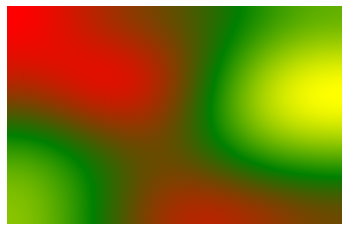

In [137]:
# Normalize scores to range [-1, 1]
scores = np.array(scores)
# scores_normalized = (scores - scores.min()) / (scores.max() - scores.min()) * 2 - 1

# Function to map sentiment score to color
def sentiment_to_color(score):
    cmap = mcolors.LinearSegmentedColormap.from_list("", ['red', 'yellow', 'green'])
    return cmap((score + 1) / 2)  # Normalize score to 0-1 for the colormap

# Create a 2D grid for the gradient
x = np.linspace(0, 1, 500)  # Horizontal axis
y = np.linspace(0, 1, 500)  # Vertical axis
X, Y = np.meshgrid(x, y)

# Create an organic-looking sentiment field
base_field = np.interp(
    np.linspace(0, len(scores_normalized) - 1, 500), np.arange(len(scores_normalized)), scores_normalized
)
base_field = np.tile(base_field, (500, 1))  # Repeat scores across rows

# Add random noise to create organic variation
# add noise + time of comment as a slider to "move" the mood
noise = np.random.normal(loc=0.0, scale=100, size=(500, 500))

# Combine the base field with noise
Z = base_field + noise

# Apply Gaussian blur to smooth the noise and make it look like an aura
Z = gaussian_filter(Z, sigma=100)

# Normalize Z to a range of [-1, 1] for sentiment mapping
Z_normalized = (Z - Z.min()) / (Z.max() - Z.min()) * 2 - 1

# Map normalized scores to colors
cmap = mcolors.LinearSegmentedColormap.from_list("", ['red', 'green', 'yellow'])
colors = cmap((Z_normalized + 1) / 2)  # Map to the colormap

# Plot the gradient
plt.imshow(colors, extent=[1, 0, 1, 0], origin='lower', aspect='auto')
plt.axis('off')  # Hide axes for a cleaner look
plt.show()